In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!pip install torchvision


In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.07MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.79MB/s]


In [5]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),

)

In [6]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)


(60000, 60000, 10000, 10000)

Image shape: torch.Size([1, 28, 28])


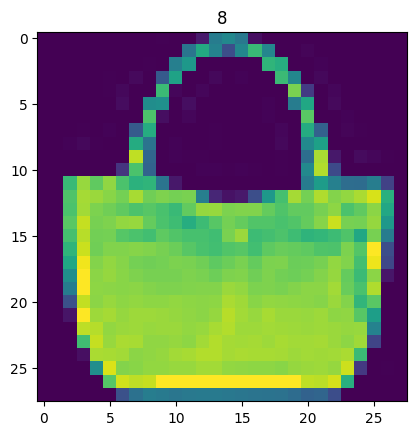

In [11]:
import matplotlib.pyplot as plt
image, label = train_data[100]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

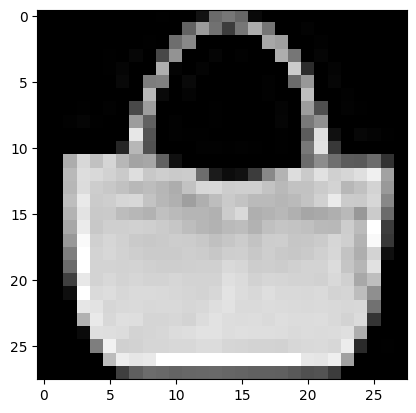

In [12]:
plt.imshow(image.squeeze() , cmap="grey")

In [13]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

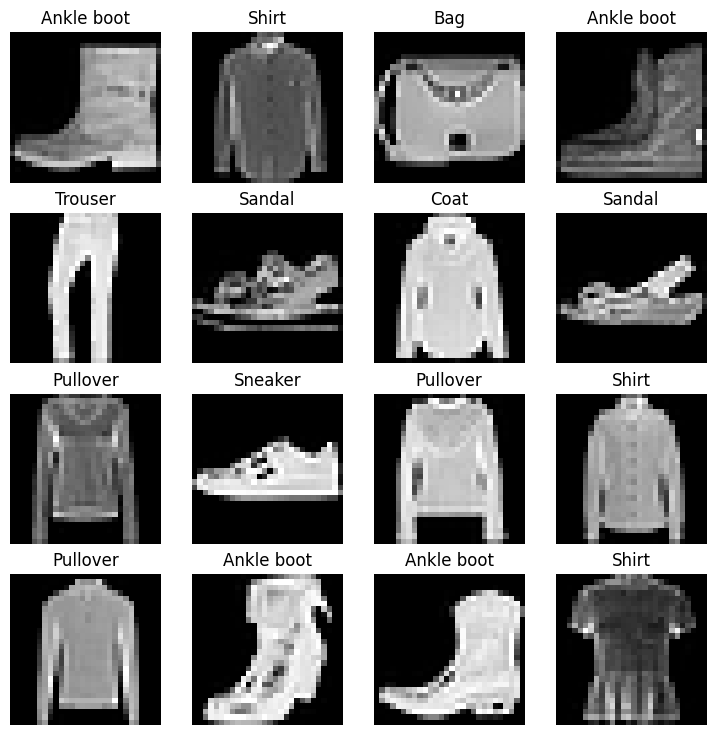

In [14]:

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32


train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)
print(f"dataloader: {train_dataloader, test_dataloader}")
print(f"length of data loader: {len(train_dataloader)} no of batches {BATCH_SIZE}")
print(f"length of dataloader: {len(test_dataloader)} no of batches {BATCH_SIZE}")

dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x7e0cf1664b10>, <torch.utils.data.dataloader.DataLoader object at 0x7e0cf170d590>)
length of data loader: 1875 no of batches 32
length of dataloader: 313 no of batches 32


In [16]:
train_image_batch, train_labels_batch = next(iter(train_dataloader))
train_image_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [17]:
flatten_model = nn.Flatten()


x = train_image_batch[0]


output = flatten_model(x)
print(f"Shape before flattening: {x.shape} ")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28]) 
Shape after flattening: torch.Size([1, 784])


In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)


In [19]:
torch.manual_seed(42)


model_0 = FashionMNISTModelV0(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [21]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Training {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)


    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Training None: 37.616 seconds


In [24]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            y_pred = model(X)


            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [25]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
next(model_1.parameters()).device

device(type='cpu')

In [33]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)


        y_pred = model(X)


        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))


        optimizer.zero_grad()


        loss.backward()


        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)


            test_pred = model(X)


            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )


        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [29]:
class FashionMNISTModelV2(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [34]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [36]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_model_2 = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30229 | Train accuracy: 10.00%
Test loss: 2.30231 | Test accuracy: 9.99%

Epoch: 1
---------
Train loss: 2.30228 | Train accuracy: 10.00%
Test loss: 2.30231 | Test accuracy: 9.99%

Epoch: 2
---------
Train loss: 2.30228 | Train accuracy: 10.00%
Test loss: 2.30231 | Test accuracy: 9.99%

Training cpu: 183.167 seconds


In [37]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 2.3023064136505127,
 'model_acc': 9.994009584664537}

In [39]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,model_2_results])
compare_results


,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV2,2.302306,9.994010


In [40]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:

            sample = torch.unsqueeze(sample, dim=0).to(device)


            pred_logit = model(sample)


            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [41]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [43]:
pred_probs= make_predictions(model=model_2,
                             data=test_samples)
pred_probs[:3]

tensor([[0.1030, 0.0933, 0.1060, 0.0963, 0.0985, 0.1013, 0.0995, 0.0991, 0.1020,
         0.1010],
        [0.1040, 0.0933, 0.1045, 0.0967, 0.0991, 0.1018, 0.0994, 0.0988, 0.1025,
         0.0999],
        [0.1030, 0.0935, 0.1057, 0.0968, 0.0980, 0.1013, 0.0994, 0.0993, 0.1019,
         0.1010]])

In [44]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([2, 2, 2, 2, 2, 2, 2, 2, 2]))

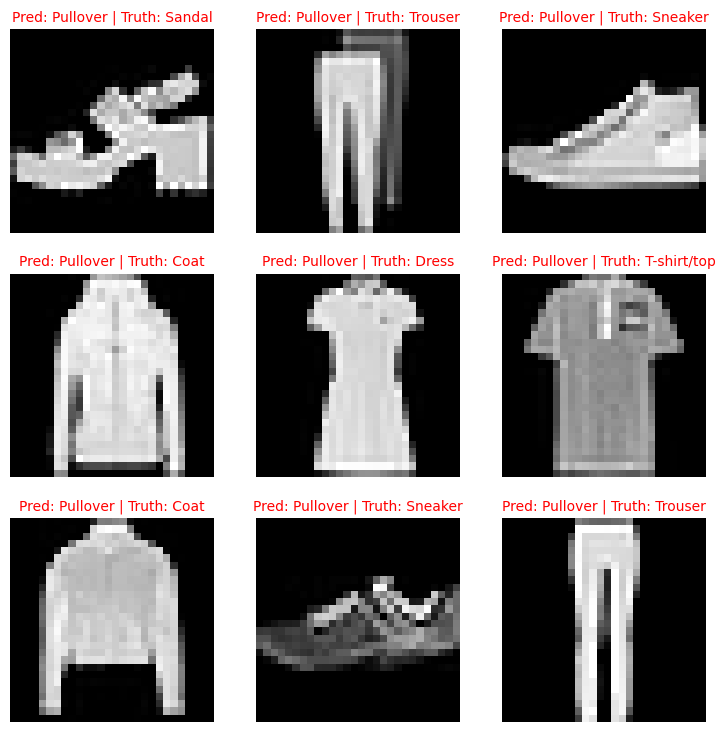

In [46]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):

  plt.subplot(nrows, ncols, i+1)


  plt.imshow(sample.squeeze(), cmap="gray")


  pred_label = class_names[pred_classes[i]]


  truth_label = class_names[test_labels[i]]


  title_text = f"Pred: {pred_label} | Truth: {truth_label}"


  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);